# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/home/guy/datasets/'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

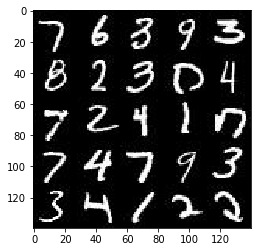

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

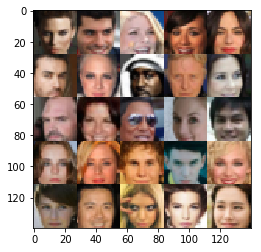

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,[None,image_height,image_width,image_channels])
    inputs_z = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/guy/anaconda3/envs/dlnd/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [37]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2   # coefficient for leaky relu
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer 1: input = 28x28x3
#         x = tf.layers.conv2d(images,64,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now 14x14x64
#         x = tf.layers.conv2d(images,64,5,2,padding='same',use_bias=False)  # now 14x14x64
        x = tf.layers.conv2d(images,32,5,2,padding='same')  # now 14x14x64
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha*x,x)
        # x = tf.nn.dropout(x,0.5)
        
#         x = tf.layers.conv2d(x,128,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))   # now 7x7x128
#         x = tf.layers.conv2d(x,128,5,2,padding='same',use_bias=False)   # now 7x7x128
        x = tf.layers.conv2d(x,64,5,2,padding='same')   # now 7x7x128
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha * x, x)

#         #layer 3: 7x7x128 --> 4x4x256
# #         x = tf.layers.conv2d(x,256,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now 4x4x256
        x = tf.layers.conv2d(x,128,5,2,padding='same',use_bias=False)  # now 4x4x256
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha * x, x)

        # flattening
        x_flat = tf.contrib.layers.flatten(x)

#         logits = tf.layers.dense(x_flat,1,kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))
        logits = tf.layers.dense(x_flat,1)
        out = tf.sigmoid(logits)
    return logits,out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 # coefficient for leaky relu
    # reuse of (trained) weights is needed when we want to generate images i.e. during inference
    # thus the reuse flag should be opposite to is_train
    with tf.variable_scope('generator', reuse=not is_train):
#         x = tf.layers.dense(z, 4 * 4 * 256,kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))
#         x = tf.layers.dense(z, 4 * 4 * 256,use_bias=False)
        x = tf.layers.dense(z, 4 * 4 * 128)
        x = tf.reshape(x, (-1, 4, 4, 128))  # now the tensor is [N,4,4,256]
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.dropout(x, 0.5)

        # Layer 2:
#         x = tf.layers.conv2d_transpose(x, 128, 4, 1, padding='valid',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now the tensor is [N,7,7,128]
#         x = tf.layers.conv2d_transpose(x, 128, 4, 1, padding='valid',use_bias=False)  # now the tensor is [N,7,7,128]
        x = tf.layers.conv2d_transpose(x, 64, 4, 1, padding='valid')  # now the tensor is [N,7,7,128]    
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
#         # x = tf.nn.dropout(x, 0.5)

#         # Layer 3:
# #         x = tf.layers.conv2d_transpose(x, 64, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now the tensor is [N,14,14,64]
        x = tf.layers.conv2d_transpose(x, 32, 5, 2, padding='same',use_bias=False)  # now the tensor is [N,14,14,64]
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)

        # Layer 4: the last layer to bring it to image size of 28x28
#         logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, 2, padding='same')

        out = tf.tanh(logits)

    return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.0
    # define a generator network
    input_fake = generator(input_z,out_channel_dim,is_train=True)

    # define a discriminator that gets real
    d_out_real,d_logits_real = discriminator(input_real)

    # define a discriminator that gets fake
    d_out_fake,d_logits_fake = discriminator(input_fake,reuse=True)


    # define loss_d_real - the loss for real images - should be compared to ones
    loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_out_real)*(1.0-smooth)))
    # define loss_d_fake - the loss for the fake images - should be compared to zeros
    loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_out_fake)))

    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_out_fake)*(1.0-smooth)))
    # define loss_g as the opposite of loss_d_fake. i.e. should be compared to ones
    loss_d=(loss_d_real + loss_d_fake)/2

    return loss_d, loss_g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # synchronize training s.t. moving around equilibrium
    equilibrium = 0.693
    margin = 0.1
    
    input_real, input_z, lr = model_inputs(data_shape[2],data_shape[1],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    d_opt,g_opt = model_opt(d_loss,g_loss,lr,beta1)
    # train the model
    saver = tf.train.Saver()
    losses=[]
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                # batch_z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))
                train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                train_loss_g = g_loss.eval({input_z:batch_z})
                if steps % 10 ==0:
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                gen_update = True
                dis_update = True
                if train_loss_d > (equilibrium + margin):
                    gen_update = False
                if train_loss_d < (equilibrium - margin):
                    dis_update = False
                
                if not (gen_update or dis_update):
                    gen_update = True
                    dis_update = True

                # Run optimizers
                if dis_update:
                    _ = sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z, lr:learning_rate})
                if gen_update:
                    _ = sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})



                if steps % 100 ==0:
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)

        saver.save(sess,'./checkpoints/generator.ckpt')
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6318... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 0.6392... Generator Loss: 0.5425
Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 0.6410... Generator Loss: 0.5477
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 0.7023... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 0.6204... Generator Loss: 0.6713


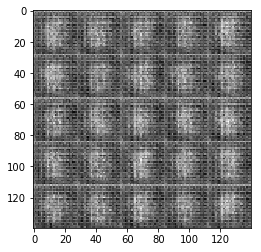

Epoch 1/2... Discriminator Loss: 0.5659... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 0.5855... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 0.5570... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 0.6737
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 0.6911


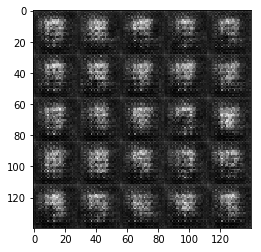

Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 0.6713
Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 0.5974... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 0.5830... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 0.6326... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 0.6241


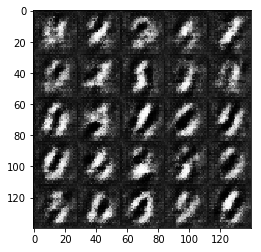

Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 0.6142... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 0.6205... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 0.6078


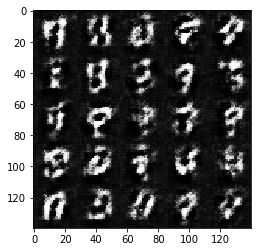

Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 0.6561
Epoch 1/2... Discriminator Loss: 0.6176... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 0.6121... Generator Loss: 0.6667
Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 0.5232
Epoch 1/2... Discriminator Loss: 0.5853... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 0.6124... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 0.6671... Generator Loss: 0.4752
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 0.6172


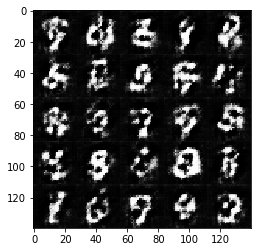

Epoch 1/2... Discriminator Loss: 0.5994... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 0.6411... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 0.5898... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 0.5949... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 0.6017... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 0.5917... Generator Loss: 0.6340
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 0.5907


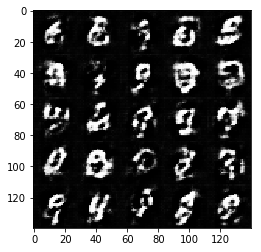

Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 0.5924... Generator Loss: 0.6356
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 0.6290
Epoch 1/2... Discriminator Loss: 0.6384... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 0.5812... Generator Loss: 0.6591
Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 0.6659


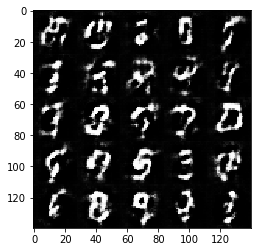

Epoch 1/2... Discriminator Loss: 0.6034... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 0.6728
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 0.6617
Epoch 1/2... Discriminator Loss: 0.5994... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 0.6056... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 0.5938... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 0.5999... Generator Loss: 0.6812


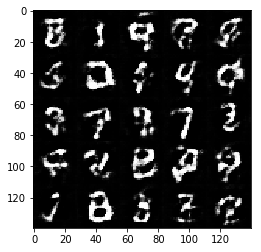

Epoch 1/2... Discriminator Loss: 0.5912... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 0.6073... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 0.6107... Generator Loss: 0.5501
Epoch 1/2... Discriminator Loss: 0.6571... Generator Loss: 0.4759
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 0.6162... Generator Loss: 0.6701
Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 0.5884... Generator Loss: 0.6458


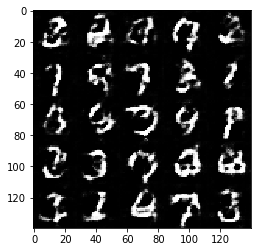

Epoch 1/2... Discriminator Loss: 0.5986... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 0.6125... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 0.6072... Generator Loss: 0.6288
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 0.5060
Epoch 2/2... Discriminator Loss: 0.5938... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 0.6266
Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 0.5879
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 0.5538


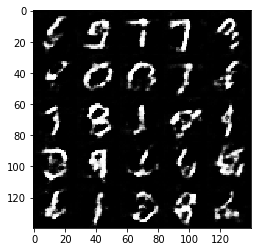

Epoch 2/2... Discriminator Loss: 0.6073... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 0.5712... Generator Loss: 0.6412
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 0.6202... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 0.5768


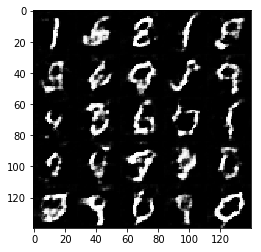

Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 0.6032... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 0.6186
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 0.5571
Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 0.5793
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 0.6331


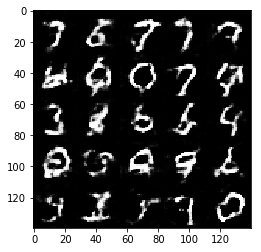

Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 0.5548
Epoch 2/2... Discriminator Loss: 0.5913... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 0.6011
Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 0.6378
Epoch 2/2... Discriminator Loss: 0.5838... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 0.6338


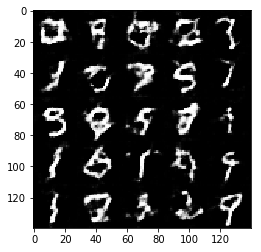

Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 0.6435... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 0.5296
Epoch 2/2... Discriminator Loss: 0.6298... Generator Loss: 0.6722
Epoch 2/2... Discriminator Loss: 0.6038... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 0.6005... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 0.5920
Epoch 2/2... Discriminator Loss: 0.6546... Generator Loss: 0.4921
Epoch 2/2... Discriminator Loss: 0.6043... Generator Loss: 0.6084


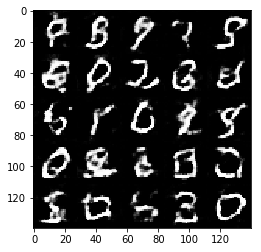

Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 0.5909... Generator Loss: 0.6420
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 0.6031... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 0.5928
Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 0.5882
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 0.5928... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 0.5990... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 0.5895


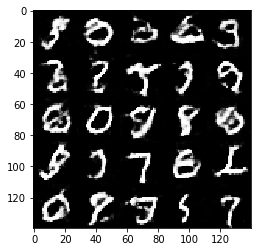

Epoch 2/2... Discriminator Loss: 0.6028... Generator Loss: 0.5698
Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 0.6071... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 0.6014... Generator Loss: 0.6690
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 0.5883... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 0.6061... Generator Loss: 0.6099


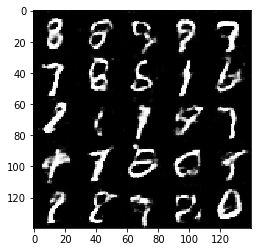

Epoch 2/2... Discriminator Loss: 0.5879... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 0.6130... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 0.6008... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 0.5924... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 0.6156... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 0.6044... Generator Loss: 0.5902


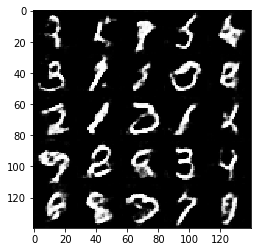

Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 0.6384... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 0.5667
Epoch 2/2... Discriminator Loss: 0.5897... Generator Loss: 0.6754
Epoch 2/2... Discriminator Loss: 0.6019... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 0.6281... Generator Loss: 0.6856


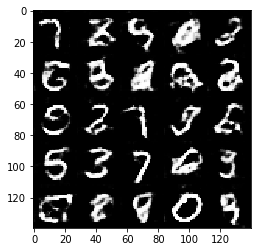

Epoch 2/2... Discriminator Loss: 0.6116... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 0.6058
Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 0.5983
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 0.6058


In [38]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 0.6573


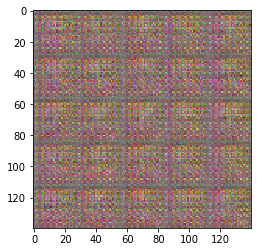

Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 0.6906


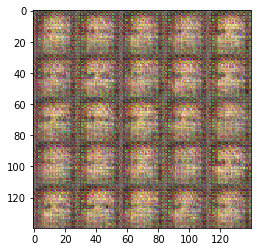

Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 0.5635... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 0.6467


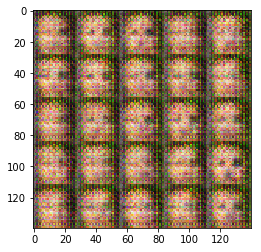

Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 0.6894


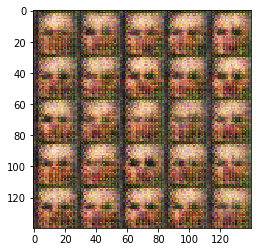

Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 0.6904


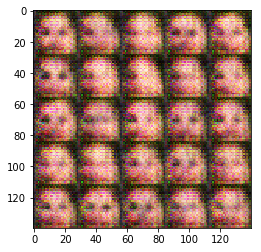

Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 0.6610


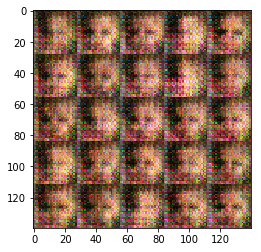

Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 0.6488


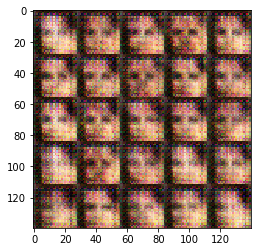

Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 0.5740... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 0.6909


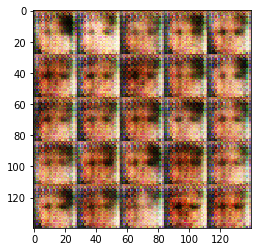

Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 0.6705


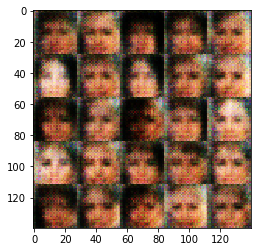

Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 0.5962... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 0.6786


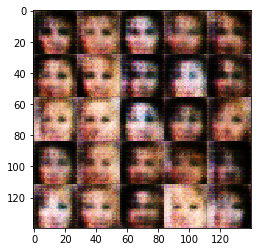

Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 0.6727


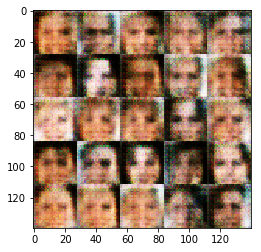

Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 0.5969


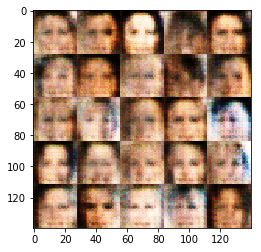

Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 0.6547


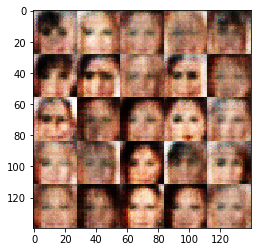

Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 0.5962... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 0.6487


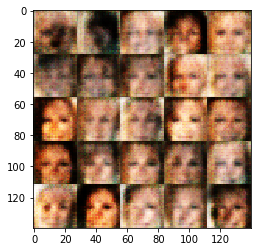

Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 0.5865... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 0.6584


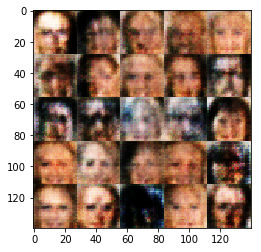

Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 0.6423


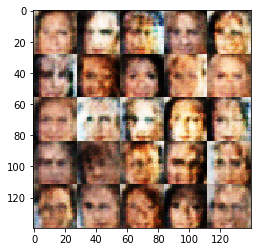

Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 0.6669


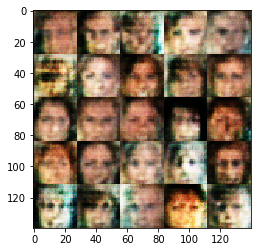

Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 0.6343


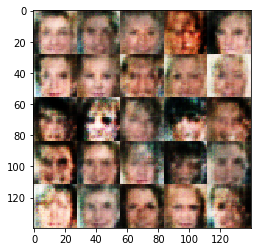

Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 0.6426


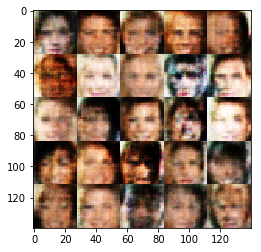

Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 0.6697


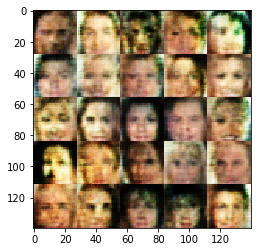

Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 0.6443


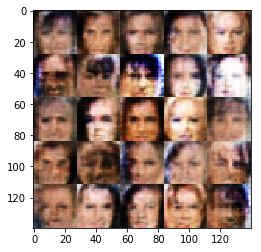

Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 0.6714


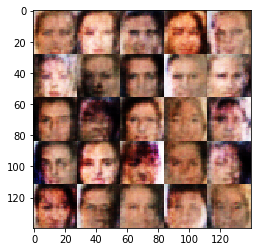

Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 0.6587


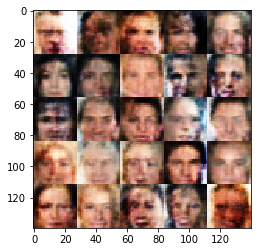

Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 0.6322


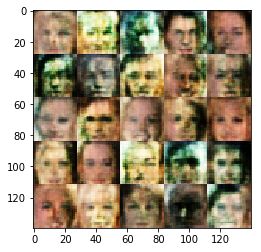

Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 0.6115


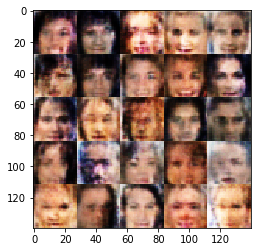

Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 0.6679


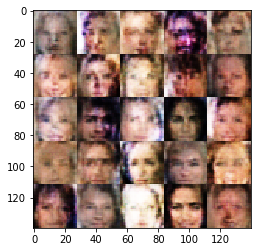

Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 0.6038


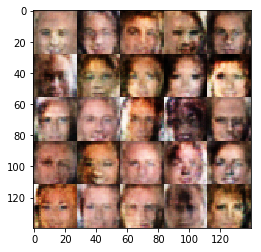

Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 0.6065


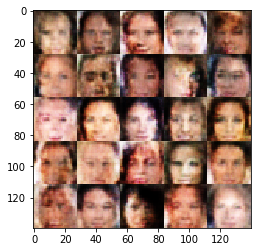

Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 0.5451


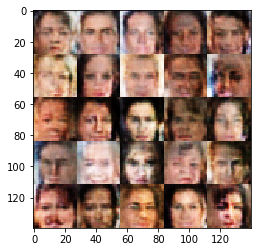

Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 0.6360


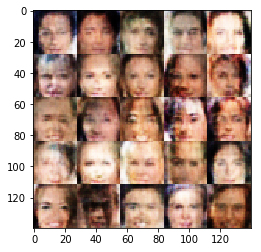

Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 0.5803


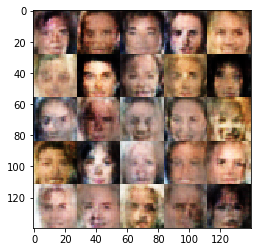

Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 0.5840


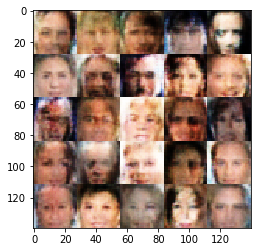

Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 0.6605


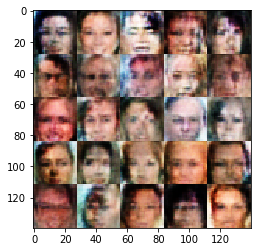

Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 0.6072


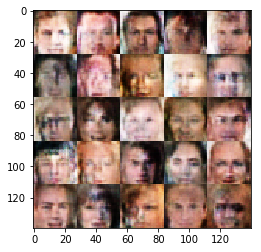

Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 0.5931


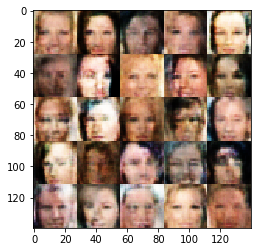

Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.6244... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 0.6421


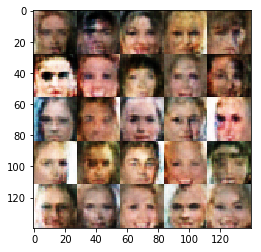

Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 0.6463


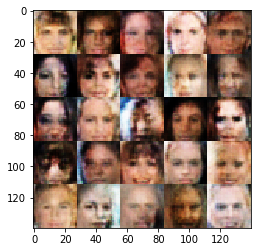

Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 0.6248


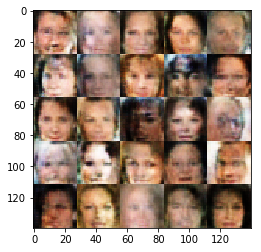

Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 0.6151


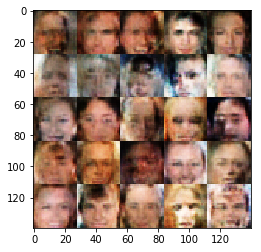

Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 0.6296


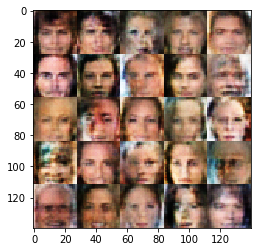

Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 0.5804


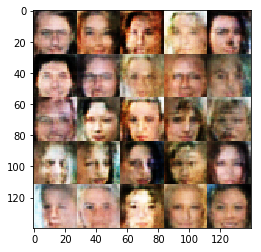

Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 0.6306


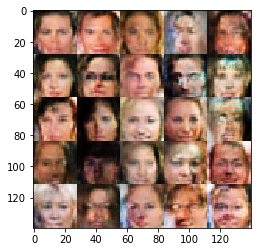

Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 0.6761


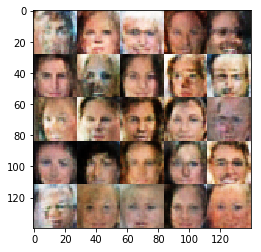

Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 0.6109... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 0.6539


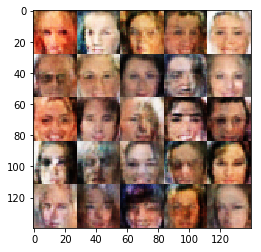

Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 0.6256


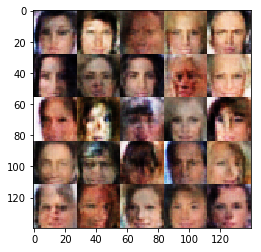

Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 0.6396


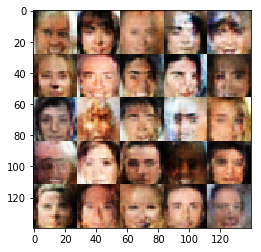

Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 0.6560


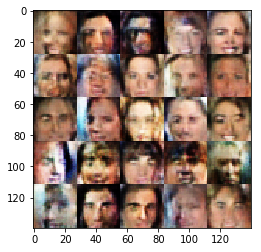

Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 0.6029


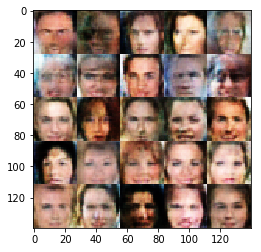

Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 0.6388


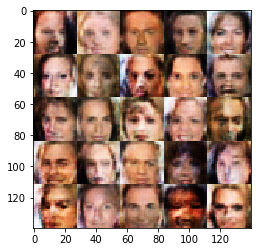

Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 0.6511


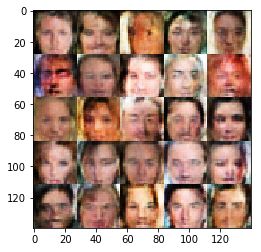

Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 0.6357


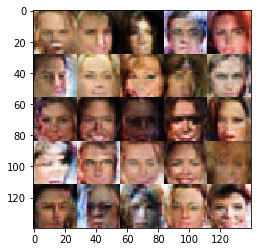

Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 0.6278


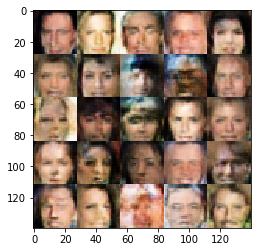

Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 0.5369


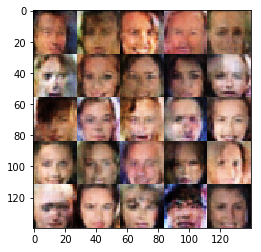

Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 0.6818


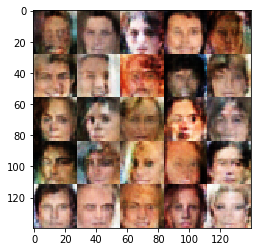

Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 0.6379


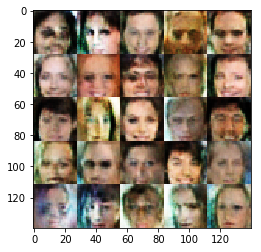

Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 0.6454


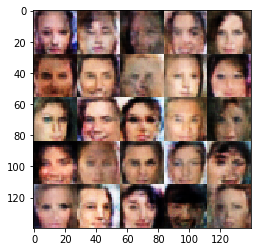

Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 0.6369


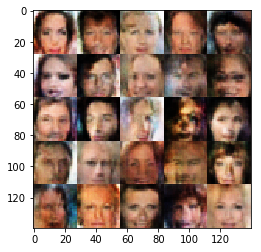

Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 0.6510


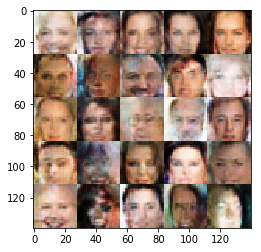

Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 0.6679


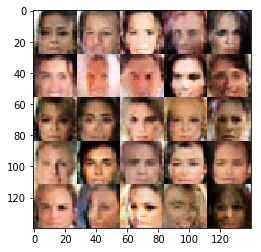

Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 0.5025


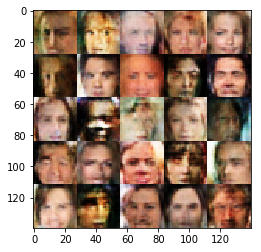

Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 0.6420


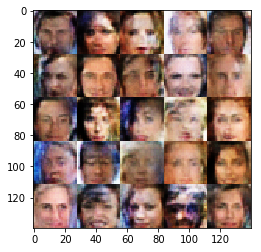

Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 0.6015... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 0.6705


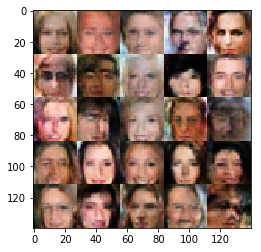

Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 0.6364... Generator Loss: 0.6773


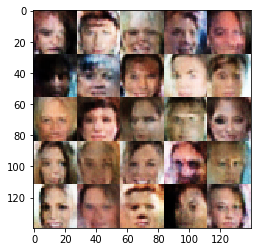

Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 0.6558


In [39]:
batch_size = 32
z_dim = 150
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.